# Synthetic Handwriting Generation (DCGAN)

**Project:** Synthetic Data Creation: Survey and Synthesis  
**Method Group:** Perceptual and Media Synthesis  
**Sub-method:** Generative Adversarial Networks (GANs) - DCGAN  
**Author:** Prajna Penmetsa

**Goal:** Synthesize realistic **Handwritten Digits (Grades)** to train optical character recognition (OCR) systems for automated grading.
- Unlike VAEs which optimize a probability lower bound, **GANs** use a game-theoretic approach where a *Generator* tries to fool a *Discriminator*.
- This notebook uses a **Deep Convolutional GAN (DCGAN)** trained on MNIST to create infinite variations of handwritten scores (0-9).

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# --- CONFIGURATION ---
IMAGE_SIZE = 64     # DCGAN works best with 64x64 (Upscaled from MNIST 28x28)
CHANNELS = 1        # Grayscale
Z_DIM = 100         # Size of the "Noise" vector (Latent Space)
FEATURES_D = 64     # Base number of filters in Discriminator
FEATURES_G = 64     # Base number of filters in Generator
BATCH_SIZE = 128
EPOCHS = 5          # GANs are slow; 5 epochs is enough for a POC on CPU/Low-GPU
LR = 0.0002         # Very low learning rate is critical for GAN stability
BETA1 = 0.5         # Momentum for Adam (Standard DCGAN value)
SEED = 42

# Setup Output Directory
OUTPUT_DIR = os.path.join("outputs", "handwriting_gan")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Saving outputs to: {os.path.abspath(OUTPUT_DIR)}")

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(SEED)

Saving outputs to: /home2/lakshmiprajna.p/synthetic-data-generation/Perceptual and Media Synthesis/GAN/outputs/handwriting_gan
Using device: cuda


Downloading/Loading MNIST...


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.82MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 113kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 903kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]


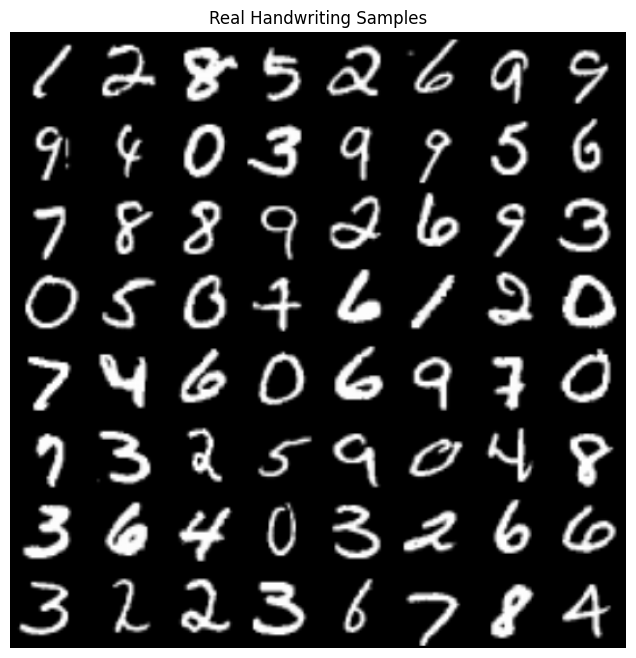

In [3]:
# Load Real Handwriting Data (MNIST)
# We resize to 64x64 to make it compatible with standard DCGAN architecture.

transforms_mnist = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS)], 
        [0.5 for _ in range(CHANNELS)]
    ) # Normalize to [-1, 1] range
])

# Download Data
print("Downloading/Loading MNIST...")
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms_mnist, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Visualize a batch of Real Data
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Handwriting Samples")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
# --- THE DISCRIMINATOR (The Art Critic) ---
# It tries to distinguish Real images from Fake ones.
# Architecture: Deep Convolutional Binary Classifier
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            # Block 1: 32 x 32
            self._block(features_d, features_d * 2, 4, 2, 1),
            # Block 2: 16 x 16
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            # Block 3: 8 x 8
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            
            # Output: 4 x 4 -> 1 x 1 (Probability)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


# --- THE GENERATOR (The Forger) ---
# It tries to create images that fool the Discriminator.
# Architecture: Transposed Convolutions (Upsampling) from Noise Vector.
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x Z_DIM x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0), # 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1), # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            
            # Output: 64x64
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), # Output must be [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# Initialization (Critical for DCGAN stability)
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# Create Models
gen = Generator(Z_DIM, CHANNELS, FEATURES_G).to(device)
disc = Discriminator(CHANNELS, FEATURES_D).to(device)

# Apply Weights
initialize_weights(gen)
initialize_weights(disc)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(BETA1, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(BETA1, 0.999))
criterion = nn.BCELoss()

print("Generator and Discriminator Initialized.")

Generator and Discriminator Initialized.


Starting Training Loop...


Epoch [0/5] Batch 0/469 	 Loss D: 0.6882, Loss G: 0.8070
Epoch [0/5] Batch 100/469 	 Loss D: 0.0146, Loss G: 4.1421
Epoch [0/5] Batch 200/469 	 Loss D: 0.7521, Loss G: 0.7736
Epoch [0/5] Batch 300/469 	 Loss D: 0.5320, Loss G: 1.9650
Epoch [0/5] Batch 400/469 	 Loss D: 0.4868, Loss G: 1.5570
Epoch [1/5] Batch 0/469 	 Loss D: 0.4784, Loss G: 1.6178
Epoch [1/5] Batch 100/469 	 Loss D: 0.5854, Loss G: 0.9121
Epoch [1/5] Batch 200/469 	 Loss D: 0.5672, Loss G: 1.0191
Epoch [1/5] Batch 300/469 	 Loss D: 0.5842, Loss G: 1.4391
Epoch [1/5] Batch 400/469 	 Loss D: 0.5709, Loss G: 1.3697
Epoch [2/5] Batch 0/469 	 Loss D: 0.5941, Loss G: 0.9343
Epoch [2/5] Batch 100/469 	 Loss D: 0.6240, Loss G: 0.9261
Epoch [2/5] Batch 200/469 	 Loss D: 0.5200, Loss G: 1.1379
Epoch [2/5] Batch 300/469 	 Loss D: 0.5544, Loss G: 1.0196
Epoch [2/5] Batch 400/469 	 Loss D: 0.5460, Loss G: 0.9553
Epoch [3/5] Batch 0/469 	 Loss D: 0.5961, Loss G: 1.0871
Epoch [3/5] Batch 100/469 	 Loss D: 0.6015, Loss G: 1.9737
Epoch

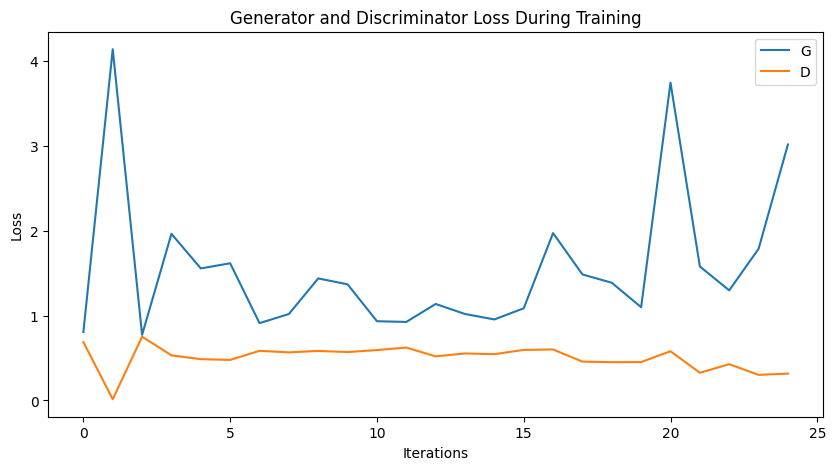

In [5]:
# Training the Adversarial Network
print("Starting Training Loop...")

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device) # Keep this to see improvement on same inputs
img_list = []
G_losses = []
D_losses = []

for epoch in range(EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        # --- 1. Train Discriminator: max log(D(x)) + log(1 - D(G(z))) ---
        disc.zero_grad()
        
        # Train on Real
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Train on Fake
        disc_fake = disc(fake.detach()).reshape(-1) # Detach so G doesn't get gradients here
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        loss_disc.backward()
        opt_disc.step()

        # --- 2. Train Generator: max log(D(G(z))) ---
        gen.zero_grad()
        output = disc(fake).reshape(-1) # Re-run discriminator on fake
        loss_gen = criterion(output, torch.ones_like(output)) # Trick D into thinking it's real (1)
        
        loss_gen.backward()
        opt_gen.step()

        # Stats
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} \t Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}")
            
            G_losses.append(loss_gen.item())
            D_losses.append(loss_disc.item())

# Save Final Training State
torch.save(gen.state_dict(), os.path.join(OUTPUT_DIR, "generator.pth"))
torch.save(disc.state_dict(), os.path.join(OUTPUT_DIR, "discriminator.pth"))
print("Training Complete & Models Saved.")

# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "gan_loss_curve.png"))
plt.show()

Saved generated samples to: outputs/handwriting_gan/Synthetic_Exam_Grades.png


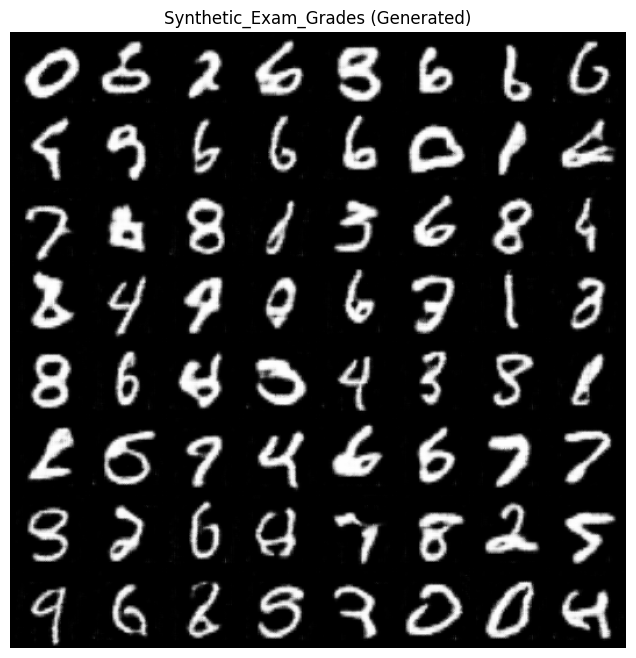

In [6]:
# --- GENERATE SYNTHETIC HANDWRITING ---
# Allows researchers to generate a batch of "N" random samples.

def generate_samples(n_samples=64, title="Synthetic_Batch"):
    gen.eval()
    with torch.no_grad():
        # 1. Create Random Noise
        noise = torch.randn(n_samples, Z_DIM, 1, 1).to(device)
        
        # 2. Generate Images
        fake_images = gen(noise)
        
        # 3. Create Grid Visualization
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title(f"{title} (Generated)")
        plt.imshow(np.transpose(vutils.make_grid(fake_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
        
        # 4. Save
        save_path = os.path.join(OUTPUT_DIR, f"{title}.png")
        plt.savefig(save_path)
        print(f"Saved generated samples to: {save_path}")
        plt.show()

# Generate a Batch of "Exam Grades"
generate_samples(64, "Synthetic_Exam_Grades")